## Evaluate metrics

We want to simulate the game process in order to know how it look like in real and which set of parameters should we choose to play effectively.
Here we will adjust following parameter:

* Number of players (2 → 4).
* Number of robots per player (1 → 4).
* Number of required mails to win (4 → 15).
* The battery option.

And we will evaluate following metrics for each set of parameters:

* The time span of the game process if we consider it takes Δt seconds for a
  player to move a robot.
* Win percentage for each player.

First, get our checkpoins from Drive and unzip it.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%unzip drive/MyDrive/checkpoints.zip > out.txt

In [3]:
%pip install -q rbgame

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 27.2 MB/s eta 0:00:00


In [4]:
%cp -r /usr/local/lib/python3.10/dist-packages/rbgame/assets .

In [53]:
import os
import time

from pprint import pprint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import yaml
from rbgame.trainer import DecentralizedTrainer
from rbgame.utils import dqn_constructor

The metrics can be evaluted with our method `DecentralizedTrainer.test(agents, eval_metrics=True)`. It runs amount of episodes and show you average time span of the game process in `'time_spans'` key and number of wins for each player in `'count_wins'` key. In training it measure the reward metric instead. For each case of parameters, we will measure metrics in **64** episodes to get average.

Following function take the grid of parameters with a discrete number of values for each and return the metrics for us. See the docstring for explanation.

In [125]:
def evalulate_metrics(
    nums_players_p: list[int]|np.ndarray,
    nums_robots_per_player_r: list[int]|np.ndarray,
    required_mails_m: list[int]|np.ndarray,
    with_battery: bool
  ) -> tuple[np.ndarray, np.ndarray]:
  """
  Compute metrics for grid of parameters.

  :param nums_players_p: List of numbers of players to iterate through
  :param nums_robots_per_player_r: List of numbers of robots per player to iterate through
  :param required_mail_m: List of numbers of required mails to iterate through
  :param with_battery: Whether to use battery or not
  :return: Tuple of time spans and number of wins for each case of parameters
  """
  # P - length of nums_players_p
  # R - length of nums_robots_per_player_r
  # M - length of required_mails_m
  assert min(nums_players_p) >= 2
  assert max(nums_players_p) <= 4
  assert min(nums_robots_per_player_r) >= 1
  assert max(nums_robots_per_player_r) <= 3
  # 4 possible colors of robot
  robot_colors = ['r', 'b', 'gr', 'p']
  # zero initialize
  time_spans_p_r_m = np.zeros((len(nums_players_p), len(nums_robots_per_player_r), len(required_mails_m)), dtype=np.float64)
  count_wins_p_r_m = np.zeros((len(nums_players_p), len(nums_robots_per_player_r), len(required_mails_m)), dtype=object)
  for p, num_players in enumerate(nums_players_p):
    for r, num_robots_per_player in enumerate(nums_robots_per_player_r):
      # for each case of number players and number robots per player, initialize agent and tester
      agent = dqn_constructor(num_players*num_robots_per_player, with_battery=with_battery)
      tester = DecentralizedTrainer(
        env_args = dict(
          colors_map='assets/csv_files/colors_map.csv',
          targets_map='assets/csv_files/targets_map.csv',
          # this is not important, we change it after
          required_mail=4,
          robot_colors=robot_colors[0:num_players],
          num_robots_per_player=num_robots_per_player,
          with_battery=with_battery,
          max_step=2000,
        ),
        num_test_envs=16,
        # for all following measurements, run 64 episodes for one sets of parameters
        episodes_per_test=64,
      )
      for m, required_mail in enumerate(tqdm(required_mails_m)):
        # set required mail for all environments
        tester.test_env.set_env_attr('required_mail', required_mail)
        # get the metrics
        test_stats = tester.test([agent]*num_players*num_robots_per_player, eval_metrics=True)
        time_spans_p_r_m[p, r, m] = test_stats['time_spans']
        count_wins_p_r_m[p, r, m] = test_stats['count_wins']

  return time_spans_p_r_m, count_wins_p_r_m

Some plotting functions.

In [150]:
def plot_multi_line(
    axis,
    time_spans_n_m :np.ndarray,
    nums_players_n: list[int]|np.ndarray|None,
    nums_robots_per_player_n: list[int]|np.ndarray|None,
    required_mails_m: list[int]|np.ndarray,
    x_label: str,
    y_label: str,
    title: str,
    legend_title: str,
) -> None:
  """
  Plot the time spans depending on number of required mails.
  For each case number of players or number of robots per player, we plot one line.
  All graph is plotted in :code:`axis`.

  :param axis: Axis to plot on
  :param time_spans_n_m: Time spans to plot
  :param nums_players_n: List of numbers of players to iterate through
  :param nums_robots_per_player_n: List of numbers of robots per player to iterate through
  :param required_mail_m: List of numbers of required mails to iterate through
  :param x_label: X axis label.
  :param y_label: Y axis label.
  :param title: Main title of the plot.
  :param legend_title: Title of the legend.
  """
  # N - length of num_players or length of num_robots_per_player
  # M - length of required_mail
  assert nums_players_n is not None or nums_robots_per_player_n is not None
  assert any([nums_players_n is None, nums_robots_per_player_n is None])
  if nums_players_n is not None:
    for i, num_players in enumerate(nums_players_n):
      axis.plot(np.array(required_mails_m), time_spans_n_m[i], label=f'{num_players} players')
  else:
    for i, num_robots_per_player in enumerate(nums_robots_per_player_n):
      axis.plot(np.array(required_mails_m), time_spans_n_m[i], label=f'{num_robots_per_player} robot per player')
  # add title, labels, and legend
  axis.set_title(title, fontsize=13)
  axis.set_xlabel(x_label, fontsize=13)
  axis.set_ylabel(y_label, fontsize=13)
  axis.legend(title=legend_title, loc="upper left", fontsize=12, title_fontsize=13)
  # show grid for better readability
  axis.grid()

In [190]:
def plot_percent_bar(
    axis,
    count_wins_m_p :np.ndarray,
    required_mails_m: list[int]|np.ndarray,
    colors_p: list[str]|np.ndarray,
    x_label: str,
    y_label: str,
    title: str,
    legend_title: str,
) -> None:
  """
  Plot some bars that show how many times each player wins depending on number of required mails.

  :param axis: Axis to plot on
  :param count_wins_m_p: Number of wins for each player for each case of number of required mails
  :param required_mail_m: List of numbers of required mails to iterate through
  :param colors_p: List of colors of players
  :param x_label: X axis label.
  :param y_label: Y axis label.
  :param title: Main title of the plot.
  :param legend_title: Title of the legend.
  """
  # P - number of players
  # M - length of required_mail_m
  # calculate percentages for each column
  percentages_m_p = count_wins_m_p / count_wins_m_p.sum(axis=1, keepdims=True) * 100
  # define categories and labels
  categories_m = [str(required_mail) for required_mail in required_mails_m]
  # create the bar chart
  for i, color in enumerate(colors_p):
    bars = axis.bar(
        categories_m,
        percentages_m_p[:, i],
        bottom=percentages_m_p[:, 0:i].sum(axis=1),
        label=color,
        color=color,
    )
    # add percentage labels
    for j, bar in enumerate(bars):
      axis.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_y() + bar.get_height() / 2,
          f'{percentages_m_p[j, i]:.1f}',
          ha='center',
          va='center',
          color='black',
          fontsize=9,
      )
  # add labels, legend, and title
  axis.set_xlabel(x_label, fontsize=10)
  axis.set_ylabel(y_label, fontsize=10)
  axis.set_title(title, fontsize=10)
  axis.legend(
      title=legend_title,
      loc="lower center",
      bbox_to_anchor=(0.5, 1.09),
      ncol=len(colors_p),
      fontsize=9,
      title_fontsize=10,
  )

### The number of robots per player is fixed.
First, we fix the number of robots per player equal to one and perform measurements when change number of players (2 → 4), required number mails (4 → 15) and the battery option.

In [132]:
# without battery
time_span, count_win = evalulate_metrics(
  nums_players_p=[2, 3, 4],
  nums_robots_per_player_r=[1],
  required_mails_m=np.arange(4, 16),
  with_battery=False,
)
# pop all draw game
for i in range(3):
  for j in range(12):
    count_win[i, 0, j].pop(None, 0)

100%|██████████| 12/12 [03:21<00:00, 16.81s/it]


In [154]:
# with battery
time_span_with_battery, count_win_with_battery = evalulate_metrics(
  nums_players_p=[2, 3, 4],
  nums_robots_per_player_r=[1],
  required_mails_m=np.arange(4, 16),
  with_battery=True,
)
for i in range(3):
  for j in range(12):
    count_win[i, 0, j].pop(None, 0)

100%|██████████| 12/12 [04:25<00:00, 22.09s/it]


Let plot our results.

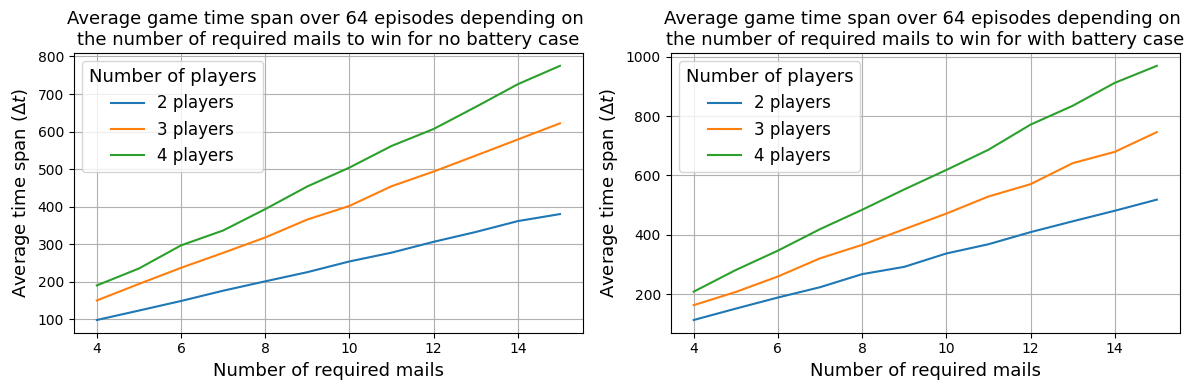

In [179]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_multi_line(
    axis=axes[0],
    time_spans_n_m=time_span[:, 0, :],
    nums_players_n=[2, 3, 4],
    nums_robots_per_player_n=None,
    required_mails_m=np.arange(4, 16),
    x_label='Number of required mails',
    y_label='Average time span $(\\Delta t)$',
    title='Average game time span over 64 episodes depending on \nthe number of required mails to win for no battery case',
    legend_title='Number of players',
)
plot_multi_line(
    axis=axes[1],
    time_spans_n_m=time_span_with_battery[:, 0, :],
    nums_players_n=[2, 3, 4],
    nums_robots_per_player_n=None,
    required_mails_m=np.arange(4, 16),
    x_label='Number of required mails',
    y_label='Average time span $(\\Delta t)$',
    title='Average game time span over 64 episodes depending on \nthe number of required mails to win for with battery case',
    legend_title='Number of players',
)
fig.tight_layout()
plt.show()

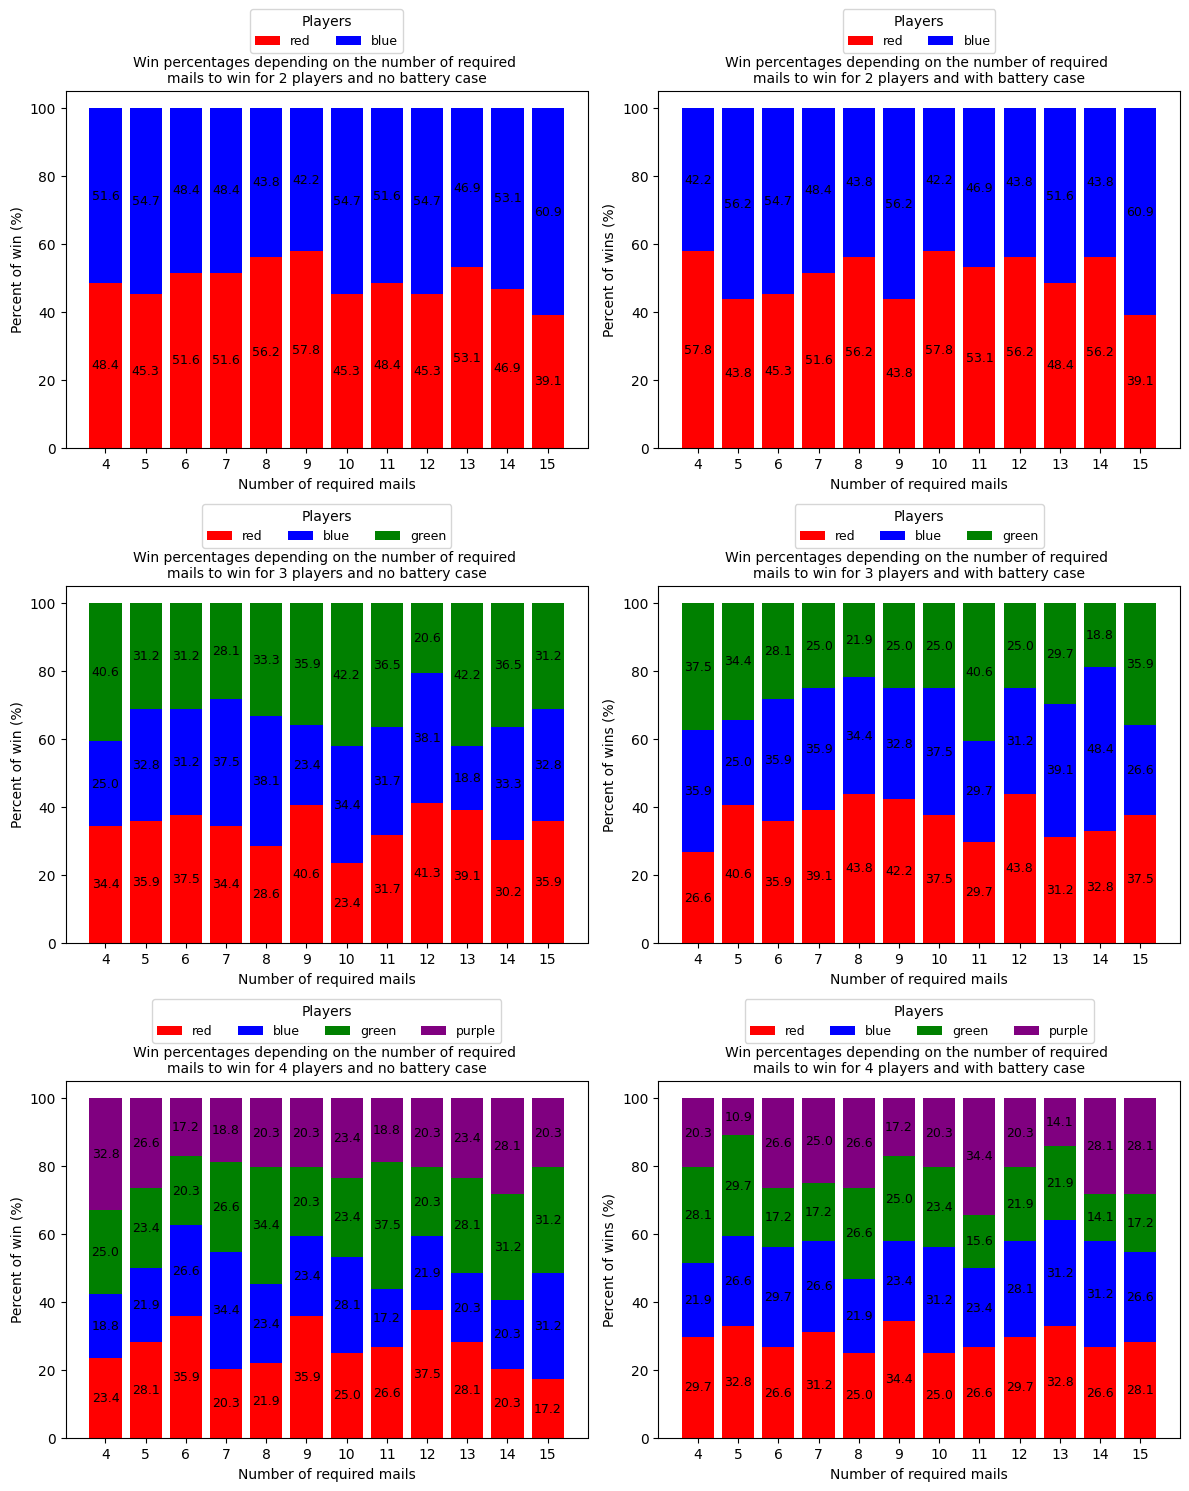

In [191]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
colors = ['red', 'blue', 'green', 'purple']
for i in range(3):
  plot_percent_bar(
      axis=axes[i, 0],
      count_wins_m_p=np.array([np.array(list(count.values())) for count in count_win[i, 0, :]]),
      required_mails_m=np.arange(4, 16),
      colors_p=colors[:i+2],
      x_label='Number of required mails',
      y_label='Percent of win (%)',
      title=f'Win percentages depending on the number of required \nmails to win for {i+2} players and no battery case',
      legend_title='Players',
  )
for i in range(3):
  plot_percent_bar(
      axis=axes[i, 1],
      count_wins_m_p=np.array([np.array(list(count.values())) for count in count_win_with_battery[i, 0, :]]),
      required_mails_m=np.arange(4, 16),
      colors_p=colors[:i+2],
      x_label='Number of required mails',
      y_label='Percent of wins (%)',
      title=f'Win percentages depending on the number of required \nmails to win for {i+2} players and with battery case',
      legend_title='Players',
  )
fig.tight_layout()
plt.show()

### The number of players is fixed.
Now, we fix the number of players equal to 2 and perform measurements when change number of robots per player (1 → 3), required number mails (4 → 15) and the battery option.

In [194]:
# without battery
time_span, count_win = evalulate_metrics(
  nums_players_p=[2],
  nums_robots_per_player_r=[1, 2, 3],
  required_mails_m=np.arange(4, 16),
  with_battery=False,
)
# pop all draw game
for i in range(3):
  for j in range(12):
    count_win[0, i, j].pop(None, 0)

100%|██████████| 12/12 [01:58<00:00,  9.88s/it]


In [195]:
# with battery
time_span_with_battery, count_win_with_battery = evalulate_metrics(
  nums_players_p=[2],
  nums_robots_per_player_r=[1, 2, 3],
  required_mails_m=np.arange(4, 16),
  with_battery=True,
)
for i in range(3):
  for j in range(12):
    count_win[0, i, j].pop(None, 0)

100%|██████████| 12/12 [02:18<00:00, 11.54s/it]


And plot the results.

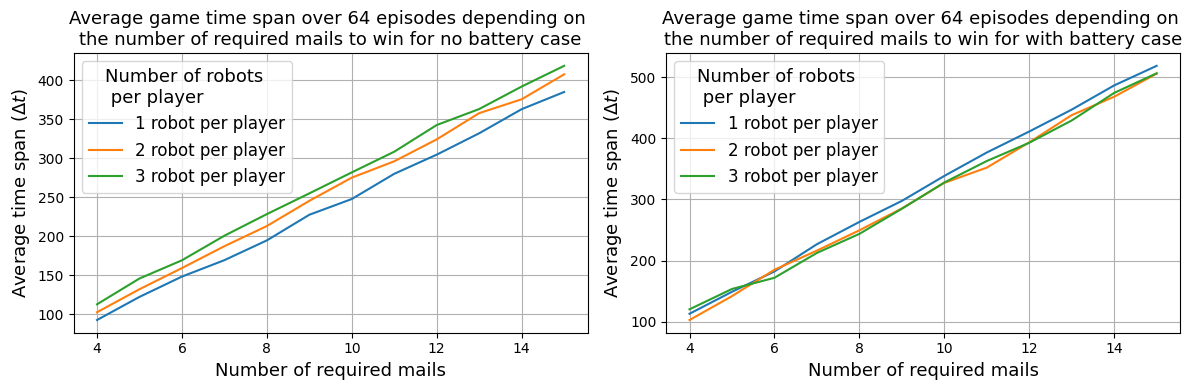

In [199]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_multi_line(
    axis=axes[0],
    time_spans_n_m=time_span[0, :, :],
    nums_players_n=None,
    nums_robots_per_player_n=[1, 2, 3],
    required_mails_m=np.arange(4, 16),
    x_label='Number of required mails',
    y_label='Average time span $(\\Delta t)$',
    title='Average game time span over 64 episodes depending on \nthe number of required mails to win for no battery case',
    legend_title='Number of robots \n per player',
)
plot_multi_line(
    axis=axes[1],
    time_spans_n_m=time_span_with_battery[0, :, :],
    nums_players_n=None,
    nums_robots_per_player_n=[1, 2, 3],
    required_mails_m=np.arange(4, 16),
    x_label='Number of required mails',
    y_label='Average time span $(\\Delta t)$',
    title='Average game time span over 64 episodes depending on \nthe number of required mails to win for with battery case',
    legend_title='Number of robots \n per player',
)
fig.tight_layout()
plt.show()

**Number of robots per player almost doesn't affects the game time span.**

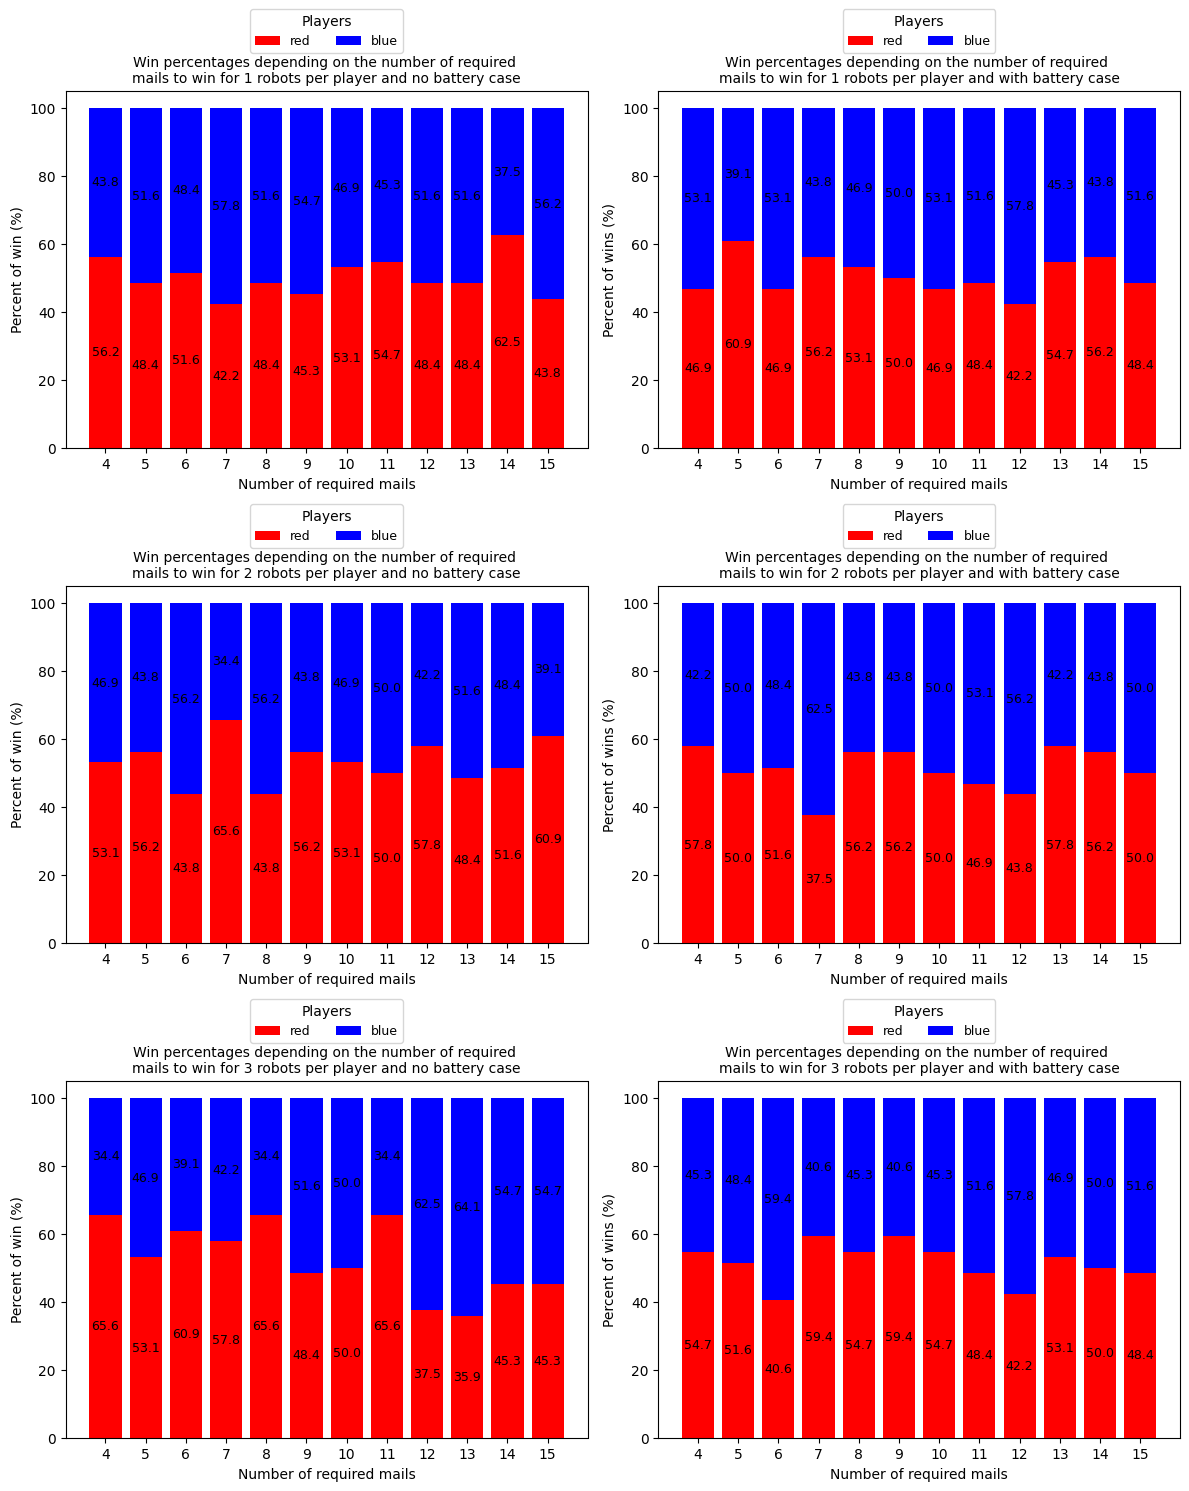

In [202]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
for i in range(3):
  plot_percent_bar(
      axis=axes[i, 0],
      count_wins_m_p=np.array([np.array(list(count.values())) for count in count_win[0, i, :]]),
      required_mails_m=np.arange(4, 16),
      colors_p=['red', 'blue'],
      x_label='Number of required mails',
      y_label='Percent of win (%)',
      title=f'Win percentages depending on the number of required \nmails to win for {i+1} robots per player and no battery case',
      legend_title='Players',
  )
for i in range(3):
  plot_percent_bar(
      axis=axes[i, 1],
      count_wins_m_p=np.array([np.array(list(count.values())) for count in count_win_with_battery[0, i, :]]),
      required_mails_m=np.arange(4, 16),
      colors_p=['red', 'blue'],
      x_label='Number of required mails',
      y_label='Percent of wins (%)',
      title=f'Win percentages depending on the number of required \nmails to win for {i+1} robots per player and with battery case',
      legend_title='Players',
  )
fig.tight_layout()
plt.show()